# Abnormality Detection in Musculoskeletal Radiographs

Author: Rajkumar Shanmuganathan

The objective is to build a machine learning model that can detect an abnormality in the X-Ray radiographs. These models can help towards providing healthcare access to the parts of the world where access to skilled radiologists is limited. According to a study on the Global Burden of Disease and the worldwide impact of all diseases found that, “musculoskeletal conditions affect more than 1.7 billion people worldwide. They are the 2nd greatest cause of disabilities, and have the 4th greatest impact on the overall health of the world population when considering both death and disabilities”. (www.usbji.org, n.d.).

This project attempts to implement deep neural network using DenseNet169 inspired from the Stanford Paper Rajpurkar, et al., 2018.

## Phase 2: Exploratory Data Analysis

In [206]:
import os
import time
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision import transforms
from collections import defaultdict
from torchvision.datasets.folder import pil_loader
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
from skimage import io, transform
from scipy import signal
import pandas as pd
from tqdm import tqdm
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import pil_loader
import os
import cv2

pd.set_option('max_colwidth', 800)

%matplotlib inline

### Define functions to extract metadata information.

In [ ]:
def create_studies_metadata_csv(category):
    """
    This function creates a csv file containing the path of studies, count of images & label.
    """
    study_data = {}
    study_label = {'positive': 1, 'negative': 0}
    study_types = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']
    i = 0
    study_data[category] = pd.DataFrame(columns=['Path', 'Count', 'Label'])
    for study_type in study_types: # Iterate throught every study types
        DATA_DIR = '../data/MURA-v1.1/%s/%s/' % (category, study_type)
        patients = list(os.walk(DATA_DIR))[0][1]  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if(study != '.DS_Store'):
                    label = study_label[study.split('_')[1]]  # get label 0 or 1
                    path = DATA_DIR + patient + '/' + study + '/'  # path to this study
                    study_data[category].loc[i] = [path, len(os.listdir(path)), label]  # add new row
                    i += 1
    study_data[category].to_csv("../data/"+category+"_study_data.csv",index = None, header=False)

def create_images_metadata_csv(category):
    """
    This function creates a csv file containing the path of images, label.
    """
    image_data = {}
    study_label = {'positive': 1, 'negative': 0}
    study_types = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']
    i = 0
    image_data[category] = pd.DataFrame(columns=['Path', 'Label'])
    for study_type in study_types: # Iterate throught every study types
        DATA_DIR = '../data/MURA-v1.1/%s/%s/' % (category, study_type)
        patients = list(os.walk(DATA_DIR))[0][1]  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if(study != '.DS_Store'):
                    label = study_label[study.split('_')[1]]  # get label 0 or 1
                    path = DATA_DIR + patient + '/' + study + '/'  # path to this study
                    for j in range(len(os.listdir(path))):
                        image_path = path + 'image%s.png' % (j + 1)
                        image_data[category].loc[i] = [image_path, label]  # add new row
                        i += 1
    image_data[category].to_csv("../data/"+category+"_image_data.csv",index = None, header=False)

def create_studytype_classes_csv(category):
    """
    This function creates a csv file containing the path of studies, count of images & label.
    """
    study_data = {}
    study_label = {'positive': 1, 'negative': 0}
    study_types = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']
    i = 0


    study_data[category] = pd.DataFrame(columns=['StudyType', 'Patient', 'Study','Label'])
    for study_type in study_types: # Iterate throught every study types
        DATA_DIR = '../data/MURA-v1.1/%s/%s/' % (category, study_type)
        patients = list(os.walk(DATA_DIR))[0][1]  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if(study != '.DS_Store'):
                    label = study_label[study.split('_')[1]]  # get label 0 or 1
                    study_data[category].loc[i] = [study_type, patient, study, label]  # add new row
                    i += 1
    study_data[category].to_csv("../data/"+category+"_studytype_classes.csv",index = None, header=False)

### Create metadata to explore the given dataset

In [ ]:
create_studies_metadata_csv('train')
create_studies_metadata_csv('valid')

create_images_metadata_csv('train')
create_images_metadata_csv('valid')

create_studytype_classes_csv('train')
create_studytype_classes_csv('valid')

### Create dataframe from the csv metadata file.

In [3]:
train_df = pd.read_csv('../data/train_study_data.csv', names=['Path', 'Count', 'Label'])
valid_df = pd.read_csv('../data/valid_study_data.csv', names=['Path', 'Count', 'Label'])

In [4]:
print(train_df.shape, valid_df.shape) #it has total 14,656 studies

(13457, 3) (1199, 3)


In [5]:
train_image_df = pd.read_csv('../data/train_image_data.csv', names=['Path', 'Label'])
valid_image_df = pd.read_csv('../data/valid_image_data.csv', names=['Path', 'Label'])

In [6]:
print(train_image_df.shape, valid_image_df.shape) #it has total 14,656 studies

(36808, 2) (3197, 2)


### Different Types of Study

In [17]:
!ls ../data/MURA-v1.1/train/

XR_ELBOW    XR_FOREARM  XR_HUMERUS  XR_WRIST
XR_FINGER   XR_HAND     XR_SHOULDER


### Finding number of Patients in each study types

In [123]:
data_cat= ['train', 'valid']
study_types = list(os.walk('../data/MURA-v1.1/train/'))[0][1] # study types, same for train and valid sets
patients_count = {}  # to store all patients count for each study type, for train and valid sets
for phase in data_cat:
    patients_count[phase] = {}
    for study_type in study_types:
        patients = list(os.walk('../data/MURA-v1.1/%s/%s' %(phase, study_type)))[0][1] # patient folder names
        patients_count[phase][study_type] = len(patients)

In [124]:
print(study_types)
print()
print(patients_count)

['XR_HAND', 'XR_HUMERUS', 'XR_FINGER', 'XR_ELBOW', 'XR_SHOULDER', 'XR_WRIST', 'XR_FOREARM']

{'train': {'XR_HAND': 1945, 'XR_HUMERUS': 587, 'XR_FINGER': 1865, 'XR_ELBOW': 1711, 'XR_SHOULDER': 2694, 'XR_WRIST': 3267, 'XR_FOREARM': 865}, 'valid': {'XR_HAND': 159, 'XR_HUMERUS': 132, 'XR_FINGER': 166, 'XR_ELBOW': 152, 'XR_SHOULDER': 173, 'XR_WRIST': 207, 'XR_FOREARM': 129}}


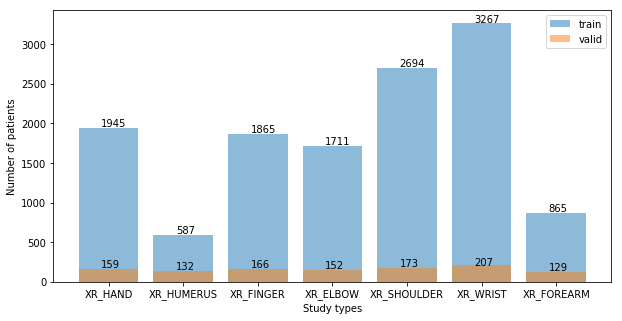

In [125]:
# plot the patient counts per study type 

fig, ax = plt.subplots(figsize=(10, 5))
for i, phase in enumerate(data_cat):
    counts = patients_count[phase].values()
    m = max(counts)
    for i, v in enumerate(counts):
        if v==m: ax.text(i-0.1, v+3, str(v))
        else: ax.text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    plt.bar(x_pos, counts, alpha=0.5)
    plt.xticks(x_pos, study_types)

plt.xlabel('Study types')
plt.ylabel('Number of patients')
plt.legend(['train', 'valid'])
plt.show()
fig.savefig('../images/pcpst.jpg', bbox_inches='tight', pad_inches=0) # name=patient count per study type

Initial data reflects imbalance distribution of study types in the dataset. So we can expect different accuracies, recall behaviour per study types.

### Plotting the distribution of count of studies by study type

In [68]:
# let's find out number of studies per study_type
train_study_count = {} # to store study counts for each study type 
for study_type in study_types:
    BASE_DIR = '../data/MURA-v1.1/train/%s/' % study_type
    train_study_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR+patient)
        train_study_count[study_type][len(studies)] += 1

# let's find out number of studies per study_type
valid_study_count = {} # to store study counts for each study type 
for study_type in study_types:
    BASE_DIR = '../data/MURA-v1.1/valid/%s/' % study_type
    valid_study_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR+patient)
        valid_study_count[study_type][len(studies)] += 1


In [25]:
study_count

{'XR_HAND': defaultdict(<function __main__.<lambda>()>,
             {1: 1875, 2: 67, 3: 3}),
 'XR_HUMERUS': defaultdict(<function __main__.<lambda>()>, {1: 582, 2: 5}),
 'XR_FINGER': defaultdict(<function __main__.<lambda>()>,
             {2: 62, 1: 1799, 3: 4}),
 'XR_ELBOW': defaultdict(<function __main__.<lambda>()>,
             {1: 1665, 2: 45, 3: 1}),
 'XR_SHOULDER': defaultdict(<function __main__.<lambda>()>,
             {1: 2582, 2: 101, 4: 4, 3: 7}),
 'XR_WRIST': defaultdict(<function __main__.<lambda>()>,
             {1: 3094, 2: 157, 3: 12, 4: 4}),
 'XR_FOREARM': defaultdict(<function __main__.<lambda>()>, {1: 853, 2: 12})}

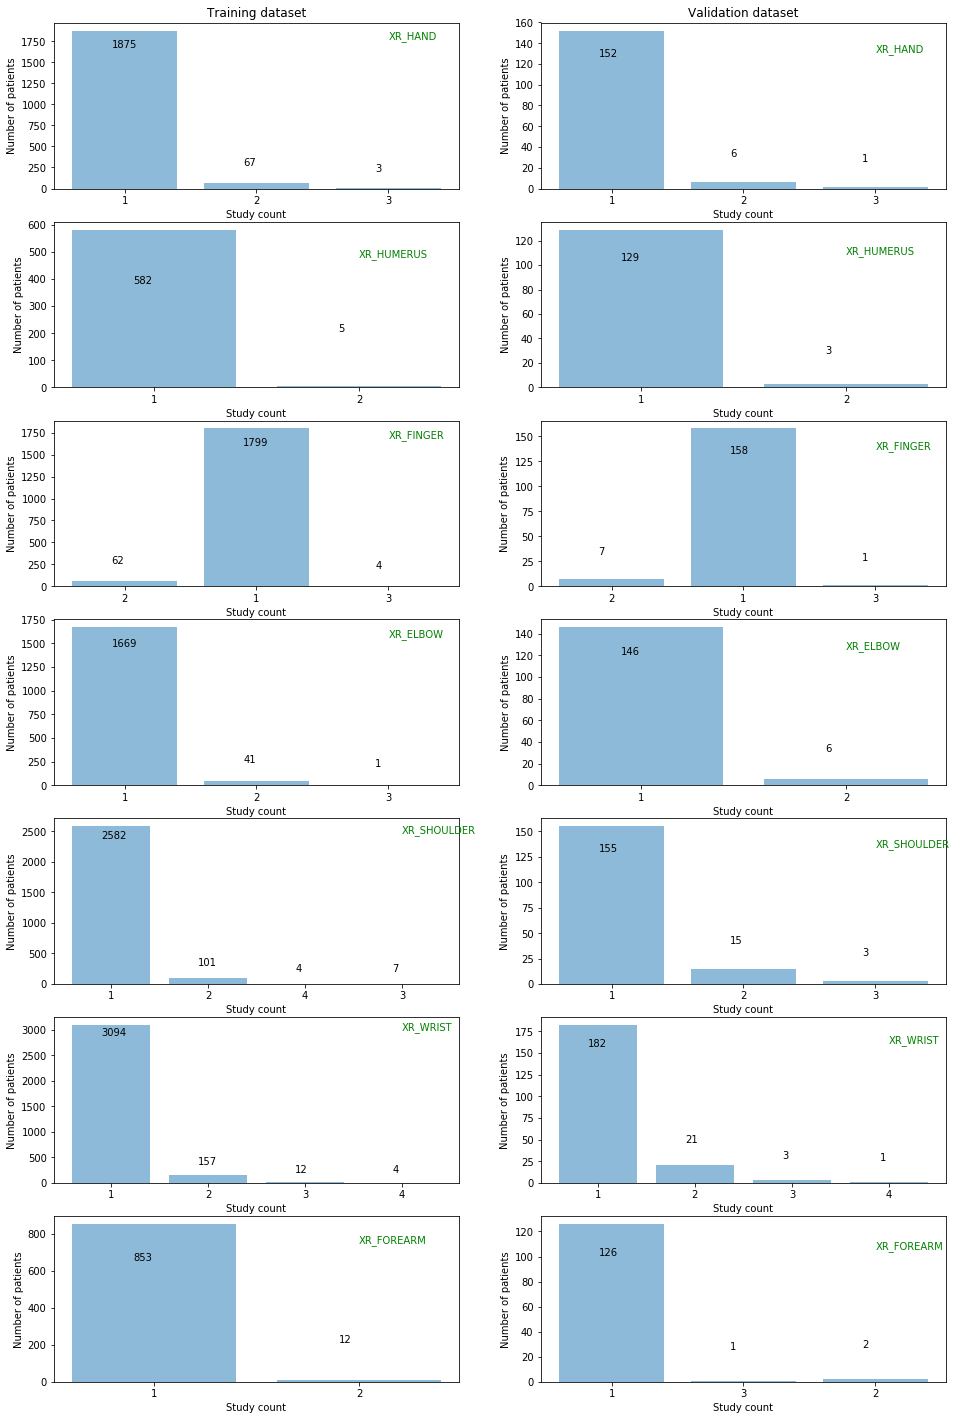

In [120]:
# plot the study count vs number of patients per study type data 
fig = plt.figure(figsize=(16, 25))
gs = fig.add_gridspec(7, 2)
for i, study_type in enumerate(train_study_count):
    ax = fig.add_subplot(gs[i,0])
    if i==0: ax.set_title('Training dataset')
    study = train_study_count[study_type]
    # text in the plot
    m = max(study.values())
    for i, v in enumerate(study.values()):
        if v==m: ax.text(i-0.1, v - 200, str(v))
        else: ax.text(i-0.1, v + 200, str(v))
    ax.text(i, m - 100, study_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(study))
    plt.bar(x_pos, study.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  study.keys())
    plt.xlabel('Study count')
    plt.ylabel('Number of patients')
for i, study_type in enumerate(valid_study_count):
    ax = fig.add_subplot(gs[i,1])
    if i==0: ax.set_title('Validation dataset')
    study = valid_study_count[study_type]
    # text in the plot
    m = max(study.values())
    for i, v in enumerate(study.values()):
        if v==m: ax.text(i-0.1, v - 25, str(v))
        else: ax.text(i-0.1, v + 25, str(v))
    ax.text(i, m - 20, study_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(study))
    plt.bar(x_pos, study.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  study.keys())
    plt.xlabel('Study count')
    plt.ylabel('Number of patients')
plt.show()
fig.savefig('../images/pcpsc.jpg', bbox_inches='tight', pad_inches=0)

The above visual shows that most of the studies are resulted in the first attempt itself. But some required multiple attempts.

### Plotting the distribution of images by study type

In [97]:
# let's find out number of views per study
train_view_count = {} # to store view counts for each study in study type, View count = number of studies which have similar number of views 
for study_type in study_types:
    BASE_DIR = '../data/MURA-v1.1/train/%s/' % study_type
    train_view_count[study_type] = defaultdict(lambda:0) # to store view count for every study in current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR + patient)
        for study in studies:
            views = os.listdir(BASE_DIR + patient + '/' + study)
            train_view_count[study_type][len(views)] += 1
# let's find out number of views per study
valid_view_count = {} # to store view counts for each study in study type, View count = number of studies which have similar number of views 
for study_type in study_types:
    BASE_DIR = '../data/MURA-v1.1/valid/%s/' % study_type
    valid_view_count[study_type] = defaultdict(lambda:0) # to store view count for every study in current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR + patient)
        for study in studies:
            views = os.listdir(BASE_DIR + patient + '/' + study)
            valid_view_count[study_type][len(views)] += 1

In [33]:
view_count

{'XR_HAND': defaultdict(<function __main__.<lambda>()>,
             {3: 1404, 2: 517, 5: 5, 1: 32, 4: 60}),
 'XR_HUMERUS': defaultdict(<function __main__.<lambda>()>,
             {2: 487, 4: 16, 3: 62, 5: 4, 1: 22, 6: 1}),
 'XR_FINGER': defaultdict(<function __main__.<lambda>()>,
             {3: 1261, 4: 132, 2: 160, 1: 359, 5: 22, 6: 1}),
 'XR_ELBOW': defaultdict(<function __main__.<lambda>()>,
             {2: 724, 4: 275, 3: 638, 5: 65, 1: 35, 6: 10, 7: 7}),
 'XR_SHOULDER': defaultdict(<function __main__.<lambda>()>,
             {4: 904, 1: 320, 3: 1004, 2: 515, 5: 72, 6: 5, 11: 1}),
 'XR_WRIST': defaultdict(<function __main__.<lambda>()>,
             {2: 661, 3: 2005, 4: 477, 1: 276, 5: 24, 7: 5, 6: 10, 8: 2}),
 'XR_FOREARM': defaultdict(<function __main__.<lambda>()>,
             {2: 669, 3: 92, 1: 87, 4: 23, 5: 5, 7: 1})}

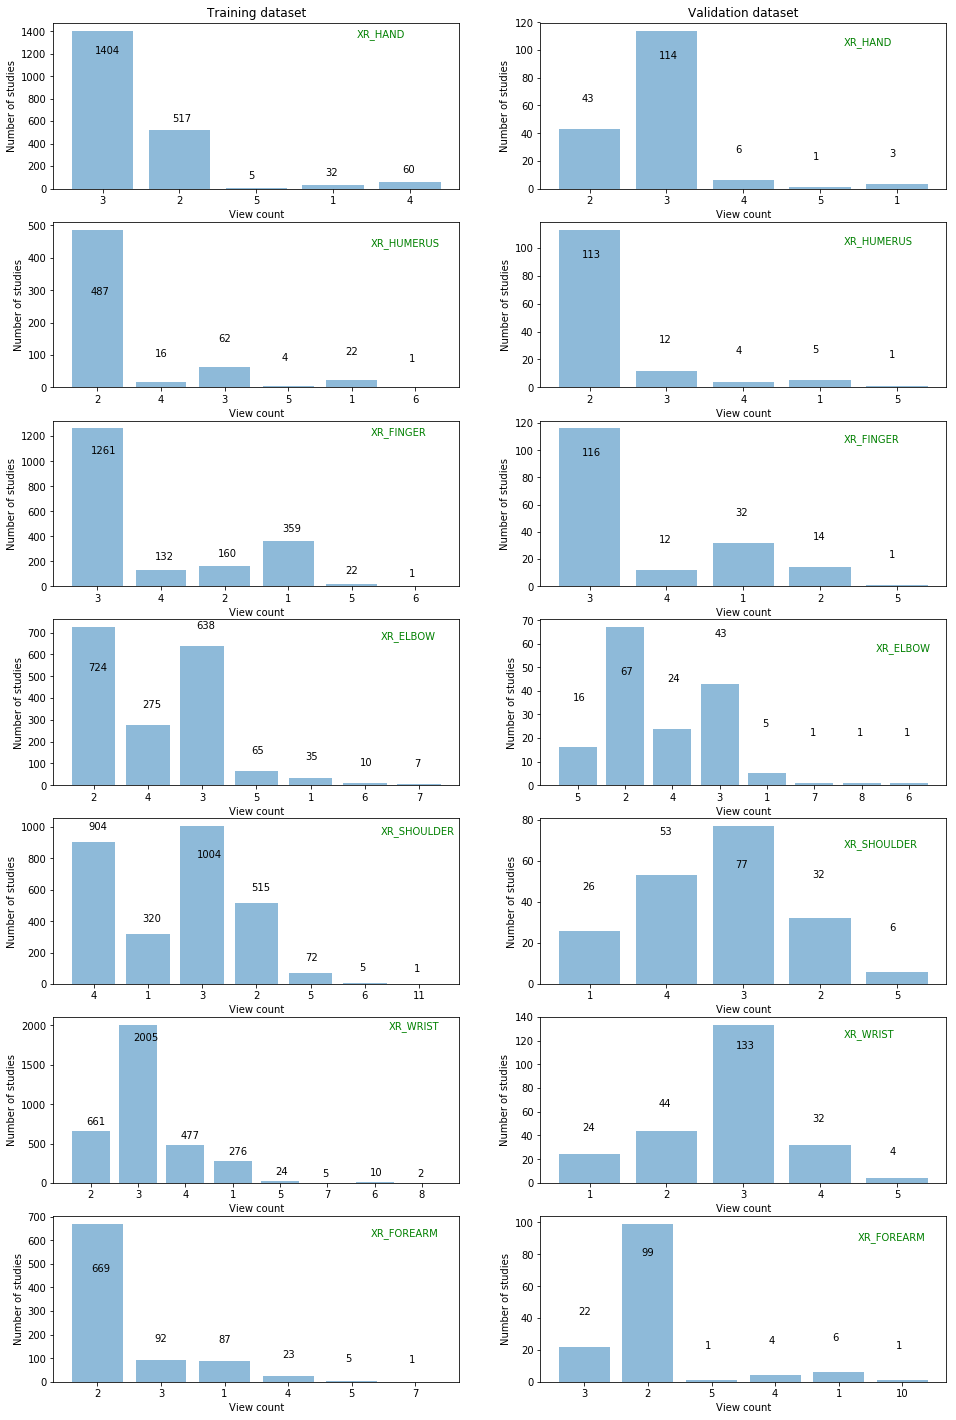

In [107]:
# plot the View count vs number of patients per study type data 
fig = plt.figure(figsize=(16, 25))
gs = fig.add_gridspec(7, 2)
for i, study_type in enumerate(train_view_count):
    ax = fig.add_subplot(gs[i,0])
    if i==0: ax.set_title('Training dataset')
    view = train_view_count[study_type]
    # text in the plot
    m = max(view.values())
    for i, v in enumerate(view.values()):
        if v==m: ax.text(i-0.1, v - 200, str(v))
        else: ax.text(i-0.1, v + 80, str(v))
    ax.text(i-0.7, m - 50, study_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(view))
    plt.bar(x_pos, view.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  view.keys())
    plt.xlabel('View count')
    plt.ylabel('Number of studies')
for i, study_type in enumerate(valid_view_count):
    ax = fig.add_subplot(gs[i,1])
    if i==0: ax.set_title('Validation dataset')
    view = valid_view_count[study_type]
    # text in the plot
    m = max(view.values())
    for i, v in enumerate(view.values()):
        if v==m: ax.text(i-0.1, v - 20, str(v))
        else: ax.text(i-0.1, v + 20, str(v))
    ax.text(i-0.7, m - 10, study_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(view))
    plt.bar(x_pos, view.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  view.keys())
    plt.xlabel('View count')
    plt.ylabel('Number of studies')
plt.show()
fig.savefig('../images/pcpvc.jpg', bbox_inches='tight', pad_inches=0)

The above visual indidates that there is highly imbalance number of images per studies. But most of the studies require 2 to 3 images. 

### Plotting the distribution of classes

In [149]:
# let's find out classes in each study type
train_study_count = {} # to store study counts for each study type 
train_df = pd.read_csv('../data/train_studytype_classes.csv', names=['StudyType', 'Patient', 'Study','Label'])
valid_df = pd.read_csv('../data/valid_studytype_classes.csv', names=['StudyType', 'Patient', 'Study','Label'])

train = train_df.groupby('StudyType')['Label'].apply(list).to_dict()
for i, data in enumerate(train):
    labels = train[data]
    train[data] = defaultdict(lambda:0)
    for label in labels:
        train[data][label] += 1
        
valid = valid_df.groupby('StudyType')['Label'].apply(list).to_dict()
for i, data in enumerate(valid):
    labels = valid[data]
    valid[data] = defaultdict(lambda:0)
    for label in labels:
        valid[data][label] += 1
valid

{'XR_ELBOW': defaultdict(<function __main__.<lambda>()>, {1: 66, 0: 92}),
 'XR_FINGER': defaultdict(<function __main__.<lambda>()>, {0: 92, 1: 83}),
 'XR_FOREARM': defaultdict(<function __main__.<lambda>()>, {1: 64, 0: 69}),
 'XR_HAND': defaultdict(<function __main__.<lambda>()>, {0: 101, 1: 66}),
 'XR_HUMERUS': defaultdict(<function __main__.<lambda>()>, {0: 68, 1: 67}),
 'XR_SHOULDER': defaultdict(<function __main__.<lambda>()>, {0: 99, 1: 95}),
 'XR_WRIST': defaultdict(<function __main__.<lambda>()>, {0: 140, 1: 97})}

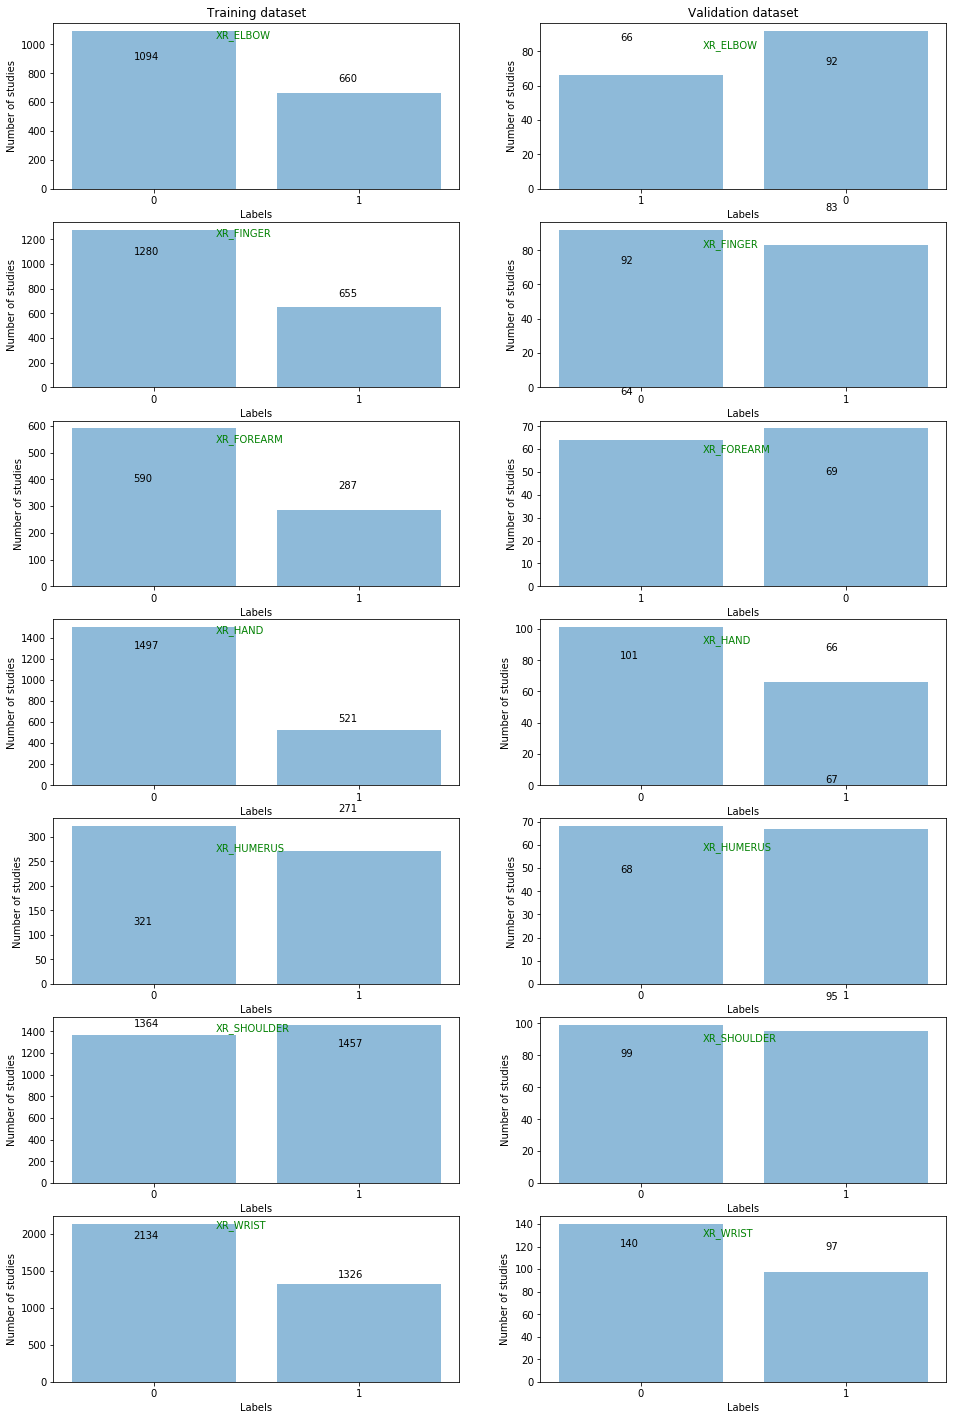

In [150]:
# plot the study count vs classes
fig = plt.figure(figsize=(16, 25))
gs = fig.add_gridspec(7, 2)
for i, study_type in enumerate(train):
    ax = fig.add_subplot(gs[i,0])
    if i==0: ax.set_title('Training dataset')
    labels = train[study_type]
    # text in the plot
    m = max(labels.values())
    for i, v in enumerate(labels.values()):
        if v==m: ax.text(i-0.1, v - 200, str(v))
        else: ax.text(i-0.1, v + 80, str(v))
    ax.text(i-0.7, m - 50, study_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, labels.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  labels.keys())
    plt.xlabel('Labels')
    plt.ylabel('Number of studies')
for i, study_type in enumerate(valid):
    ax = fig.add_subplot(gs[i,1])
    if i==0: ax.set_title('Validation dataset')
    labels = valid[study_type]
    # text in the plot
    m = max(labels.values())
    for i, v in enumerate(labels.values()):
        if v==m: ax.text(i-0.1, v - 20, str(v))
        else: ax.text(i-0.1, v + 20, str(v))
    ax.text(i-0.7, m - 10, study_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, labels.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  labels.keys())
    plt.xlabel('Labels')
    plt.ylabel('Number of studies')
plt.show()
fig.savefig('../images/pcplc.jpg', bbox_inches='tight', pad_inches=0)

Again the above data shows imbalance between classes in each study types. XR_HAND, XR_FOREARM, XR_FINGER & XR_ELBOW has different distribution between training & validation. So it will be interesting to see how the model performs against the validation dataset.

In [225]:
# look at the pixel values
io.imread(img_path)[0]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

## Plotting images

In [223]:
train_mat = train_image_df.as_matrix()
valid_mat = valid_image_df.as_matrix()

/Users/rshanm200/Softwares/anaconda3/envs/DenseNet-MURA-PyTorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/rshanm200/Softwares/anaconda3/envs/DenseNet-MURA-PyTorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### Negative labels

../data/MURA-v1.1/train/XR_FINGER/patient04044/study1_negative/image3.png
../data/MURA-v1.1/train/XR_WRIST/patient07716/study1_negative/image1.png
../data/MURA-v1.1/train/XR_WRIST/patient08719/study1_negative/image1.png
../data/MURA-v1.1/train/XR_FINGER/patient04545/study1_negative/image2.png
../data/MURA-v1.1/train/XR_SHOULDER/patient02498/study1_negative/image4.png
../data/MURA-v1.1/train/XR_FINGER/patient04046/study1_negative/image3.png
../data/MURA-v1.1/train/XR_FINGER/patient04831/study1_negative/image1.png
../data/MURA-v1.1/train/XR_WRIST/patient08585/study1_negative/image2.png
../data/MURA-v1.1/train/XR_HUMERUS/patient03134/study1_negative/image1.png


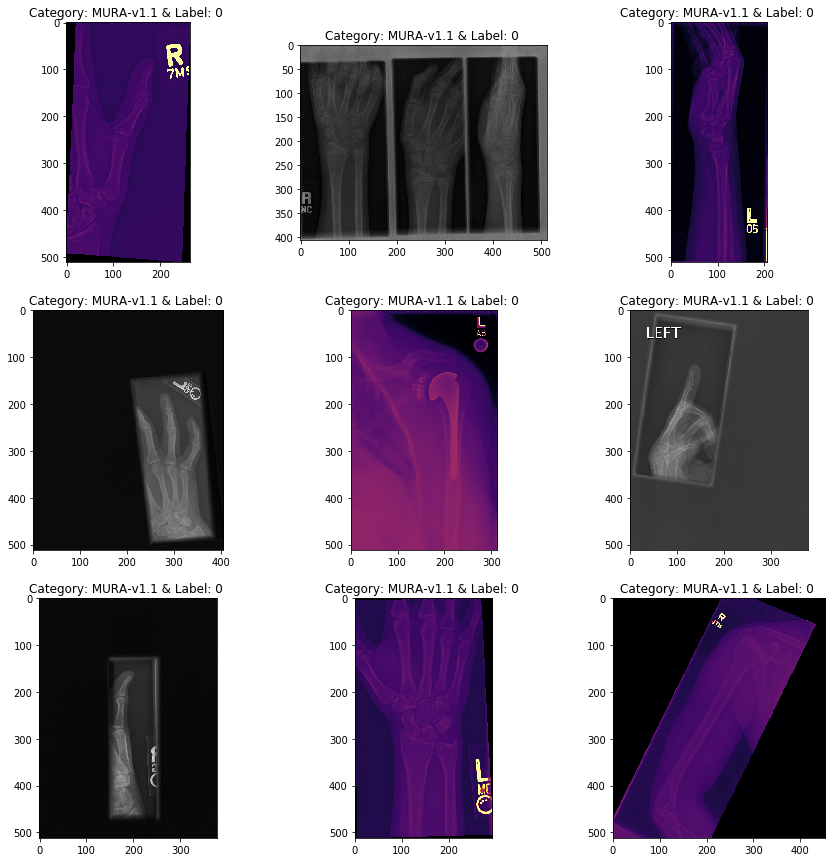

In [204]:
fig = plt.figure(1,figsize=(15,15))
negative = train_mat[train_mat[:,1]==0,:]
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ix = np.random.randint(0, len(negative)) # randomly select a index
    img_path = negative[ix][0]
    print(img_path)
    ax.imshow(io.imread(img_path), cmap='inferno')
    cat = img_path.split('/')[2] # get the radiograph category
    plt.title('Category: %s & Label: %d ' %(cat, negative[ix][1]))
plt.show()

### Positive Labels

../data/MURA-v1.1/train/XR_WRIST/patient06423/study1_positive/image1.png
../data/MURA-v1.1/train/XR_SHOULDER/patient00649/study1_positive/image2.png
../data/MURA-v1.1/train/XR_SHOULDER/patient00567/study1_positive/image2.png
../data/MURA-v1.1/train/XR_WRIST/patient07384/study1_positive/image3.png
../data/MURA-v1.1/train/XR_FINGER/patient03654/study1_positive/image1.png
../data/MURA-v1.1/train/XR_WRIST/patient07076/study1_positive/image1.png
../data/MURA-v1.1/train/XR_WRIST/patient07340/study1_positive/image2.png
../data/MURA-v1.1/train/XR_FINGER/patient03256/study1_positive/image1.png
../data/MURA-v1.1/train/XR_WRIST/patient03853/study1_positive/image2.png


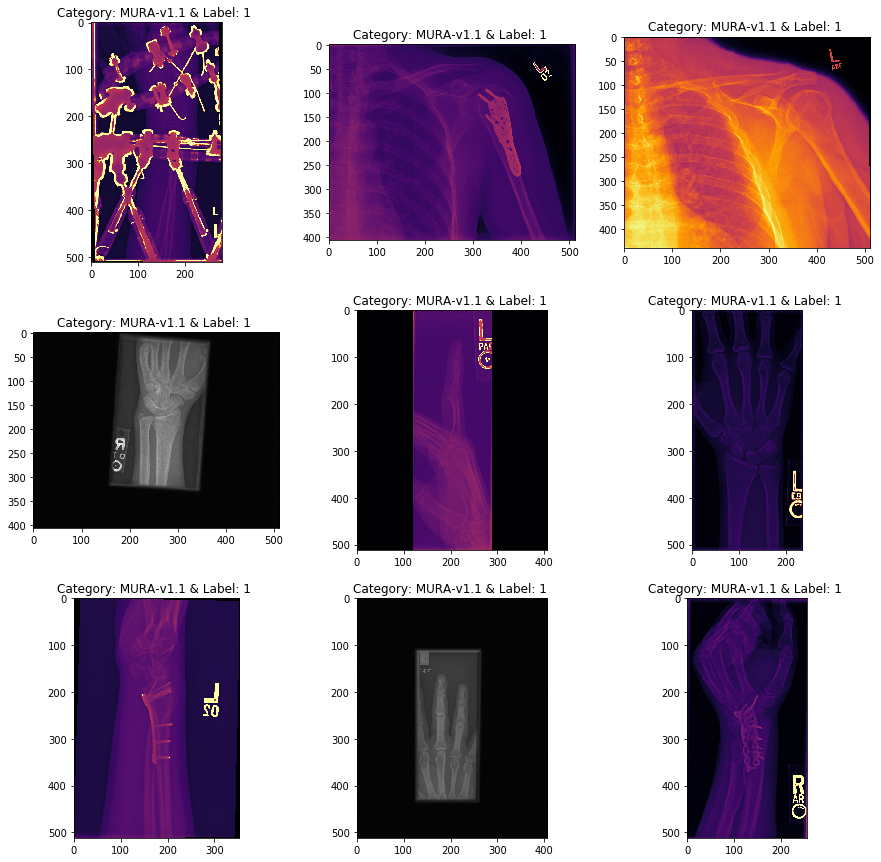

In [205]:
fig = plt.figure(1,figsize=(15,15))
positive = train_mat[train_mat[:,1]==1,:]
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ix = np.random.randint(0, len(positive)) # randomly select a index
    img_path = positive[ix][0]
    print(img_path)
    ax.imshow(io.imread(img_path), cmap='inferno')
    cat = img_path.split('/')[2] # get the radiograph category
    plt.title('Category: %s & Label: %d ' %(cat, positive[ix][1]))
plt.show()

In [208]:
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

### Sample image shape

In [238]:
np.array(io.imread(img_path)).shape

(512, 229)